# MAPK8IP3
[neurodevelopmental disorder with or without variable brain abnormalities (NEDBA)](https://omim.org/entry/618443) is caused by heterozygous mutation in the MAPK8IP3 gene.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.6.dev0


## MAPK8IP3
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for ASPM.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service

gene_symbol = 'MAPK8IP3'
mane_tx_id = 'NM_001318852.2'
mane_protein_id = 'NP_001305781.1' # C-Jun-amino-terminal kinase-interacting protein 3 isoform 3
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets


phenopacket_store_release = '0.1.24'
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
qc.summarize()

Individuals Processed: 100%|██████████| 20/20 [00:00<00:00, 51.77 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
19,Global developmental delay
11,Hypotonia
10,Thin corpus callosum
7,"Intellectual disability, moderate"
6,Intellectual disability
6,Spastic diplegia
6,Delayed ability to walk
6,Seizure
5,Cerebral atrophy
5,Thin upper lip vermilion


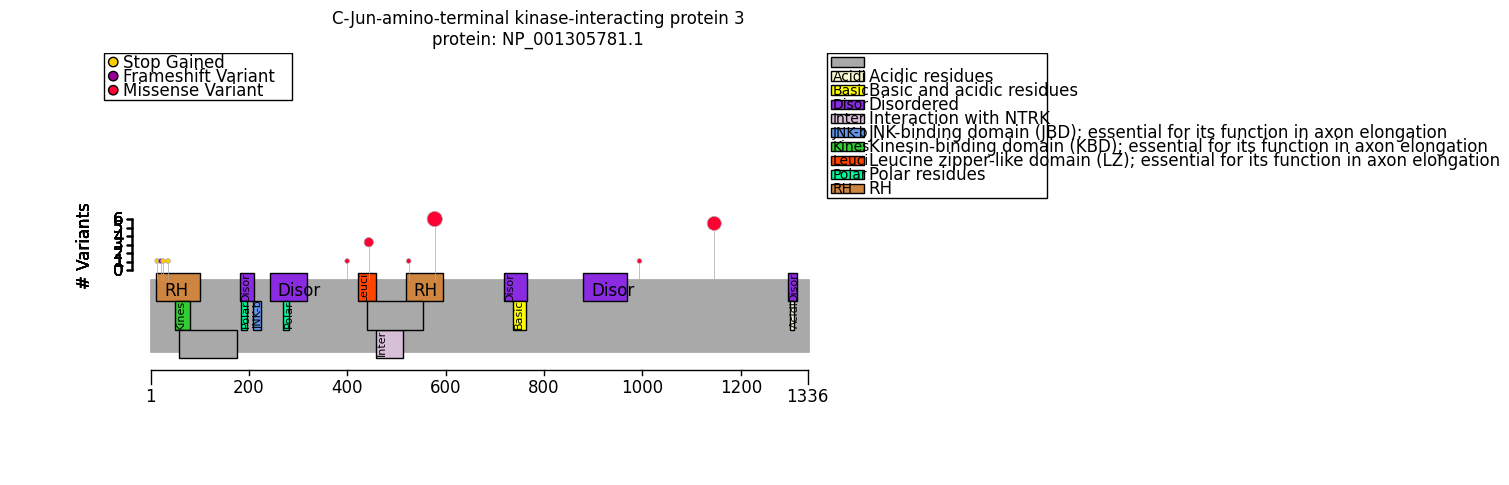

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

mapk8ip3_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
mapk8ip3_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort=cohort)

Count,Name,Type,Coordinates,Variants
4,RH1,Domain,13 - 100,p.Tyr15Ter; p.Glu27Ter; p.Tyr37Ter; p.Gly22AlafsTer3
0,Kinesin-binding domain (KBD); essential for its function in axon elongation,Region,51 - 80,
0,,Coiled coil,59 - 177,
0,Disordered,Region,183 - 211,
0,Polar residues,Compositional bias,185 - 196,
0,JNK-binding domain (JBD); essential for its function in axon elongation,Region,210 - 225,
0,Disordered,Region,244 - 318,
0,Polar residues,Compositional bias,271 - 281,
2,Leucine zipper-like domain (LZ); essential for its function in axon elongation,Region,424 - 458,p.Leu445Pro
3,,Coiled coil,441 - 554,p.Arg526Gln; p.Leu445Pro


# Genotype-Phenotype Correlation (GPC) Analysis

In [7]:
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
from gpsea.analysis.pcats import configure_hpo_term_analysis

pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)
analysis = configure_hpo_term_analysis(hpo)

In [8]:
from gpsea.view import MtcStatsViewer
from gpsea.model.genome import Region
from gpsea.analysis.predicate import protein_region

from gpsea.analysis.clf import monoallelic_classifier

n_term = protein_region(region=Region(0, 600), tx_id=mane_tx_id)
n_term_classifier = monoallelic_classifier(
    a_predicate=n_term,
    b_predicate=~n_term,
    a_label="N term",
    b_label="other"
)

n_term_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=n_term_classifier,
    pheno_clfs=pheno_clfs
)

viewer = MtcStatsViewer()
viewer.process(n_term_result)

Reason,Count
Skip terms if all counts are identical to counts for a child term,4
"Skipping ""general"" level terms",63
Skipping terms that are rare on the cohort level (in less than 40% of the cohort members),186


In [9]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=n_term_result)

Allele group,N term,other,Corrected p values,p values
Prominent nasal bridge [HP:0000426],1/13 (8%),3/6 (50%),1.0,0.070949
Short philtrum [HP:0000322],0/13 (0%),2/6 (33%),1.0,0.087719
Anteverted nares [HP:0000463],0/13 (0%),2/6 (33%),1.0,0.087719
Lateral ventricle dilatation [HP:0006956],0/8 (0%),2/4 (50%),1.0,0.090909
Thick eyebrow [HP:0000574],0/12 (0%),2/6 (33%),1.0,0.098039
...,...,...,...,...
Spasticity [HP:0001257],7/7 (100%),3/3 (100%),1.0,1.000000
Upper motor neuron dysfunction [HP:0002493],7/7 (100%),3/3 (100%),1.0,1.000000
Abnormal cerebral morphology [HP:0002060],8/8 (100%),5/5 (100%),1.0,1.000000
Abnormal brain morphology [HP:0012443],9/9 (100%),5/5 (100%),1.0,1.000000


In [10]:
from gpsea.analysis.predicate import variant_key

# test most common variant
arg579cys = variant_key("16_1762843_1762843_C_T") # c.1735C>T; p.Arg579Cys

arg579cys_clf = monoallelic_classifier(
    a_predicate=arg579cys,
    b_predicate= ~arg579cys,
    a_label='p.Arg579Cys', 
    b_label='Other variant'
)
arg579cys_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=arg579cys_clf,
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo, arg579cys_result)

Allele group,p.Arg579Cys,Other variant,Corrected p values,p values
Thin corpus callosum [HP:0033725],6/6 (100%),4/13 (31%),0.736842,0.010836
Seizure [HP:0001250],4/5 (80%),2/13 (15%),0.738095,0.021709
Reduced cerebral white matter volume [HP:0034295],2/3 (67%),0/11 (0%),0.747253,0.032967
Spastic diplegia [HP:0001264],4/6 (67%),2/13 (15%),0.782581,0.046034
Spastic paraplegia [HP:0001258],1/2 (50%),0/11 (0%),1.000000,0.153846
...,...,...,...,...
Abnormal cerebral white matter morphology [HP:0002500],6/6 (100%),5/5 (100%),1.000000,1.000000
Abnormal cerebral subcortex morphology [HP:0010993],6/6 (100%),5/5 (100%),1.000000,1.000000
Abnormal cerebral morphology [HP:0002060],6/6 (100%),7/7 (100%),1.000000,1.000000
Abnormal brain morphology [HP:0012443],6/6 (100%),8/8 (100%),1.000000,1.000000


In [11]:
from gpsea.analysis.predicate import protein_feature
rh2 = protein_feature(feature_id="RH2", protein_metadata=protein_meta)
rh2_monoallelic_clf = monoallelic_classifier(
    a_predicate=rh2,
    b_predicate= ~rh2,
    a_label='RH2', 
    b_label='Other region'
)
rh2_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=rh2_monoallelic_clf,
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo, rh2_result)

Allele group,RH2,Other region,Corrected p values,p values
Thin corpus callosum [HP:0033725],6/7 (86%),4/12 (33%),1.0,0.057276
Reduced cerebral white matter volume [HP:0034295],2/4 (50%),0/10 (0%),1.0,0.065934
Seizure [HP:0001250],4/6 (67%),2/12 (17%),1.0,0.107035
Spastic diplegia [HP:0001264],4/7 (57%),2/12 (17%),1.0,0.128741
Hypotonia [HP:0001252],2/6 (33%),9/12 (75%),1.0,0.141403
...,...,...,...,...
Abnormal brain morphology [HP:0012443],6/6 (100%),8/8 (100%),1.0,1.000000
Morphological central nervous system abnormality [HP:0002011],6/6 (100%),8/8 (100%),1.0,1.000000
Global developmental delay [HP:0001263],7/7 (100%),12/12 (100%),1.0,1.000000
Neurodevelopmental delay [HP:0012758],7/7 (100%),12/12 (100%),1.0,1.000000


In [12]:
from gpsea.analysis.clf import sex_classifier

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)

summarize_hpo_analysis(hpo, mf_result)

Sex,FEMALE,MALE,Corrected p values,p values
Ataxia [HP:0001251],0/7 (0%),2/6 (33%),1.0,0.192308
Short philtrum [HP:0000322],2/9 (22%),0/10 (0%),1.0,0.210526
Anteverted nares [HP:0000463],2/9 (22%),0/10 (0%),1.0,0.210526
Thin corpus callosum [HP:0033725],6/9 (67%),4/10 (40%),1.0,0.369850
Cerebellar atrophy [HP:0001272],0/7 (0%),1/5 (20%),1.0,0.416667
...,...,...,...,...
Morphological central nervous system abnormality [HP:0002011],8/8 (100%),6/6 (100%),1.0,1.000000
Global developmental delay [HP:0001263],9/9 (100%),10/10 (100%),1.0,1.000000
Neurodevelopmental delay [HP:0012758],9/9 (100%),10/10 (100%),1.0,1.000000
Intellectual disability [HP:0001249],9/9 (100%),10/10 (100%),1.0,1.000000


# Summary

In [13]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

f_results = (
    GPAnalysisResultSummary.from_multi(
        result=n_term_result
    ),
     GPAnalysisResultSummary.from_multi(
        result=arg579cys_result
    ),
     GPAnalysisResultSummary.from_multi(
        result=rh2_result
    ),
       GPAnalysisResultSummary.from_multi(
        result=mf_result
    ),
)

caption = "No significant association identified."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=f_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [14]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
N term,other,68,0
Genotype (A),Genotype (B),Tests performed,Significant tests
p.Arg579Cys,Other variant,68,0
Genotype (A),Genotype (B),Tests performed,Significant tests
RH2,Other region,68,0
Genotype (A),Genotype (B),Tests performed,Significant tests
FEMALE,MALE,68,0


In [15]:
summarizer.process_latex(report=report, protein_fig=mapk8ip3_fig)

Figure saved to ../../supplement/img/MAPK8IP3_protein_diagram-draft.pdf
Output to ../../supplement/tex/MAPK8IP3_summary_draft.tex
